In [30]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import os
import sys
from pathlib import Path
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Add project root to path for importing custom modules
project_root = str(Path.cwd().parent) if 'notebooks' in str(Path.cwd()) else str(Path.cwd())
if project_root not in sys.path:
    sys.path.append(project_root)

# Download required NLTK data
import nltk
nltk.download('vader_lexicon', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('wordnet', quiet=True)

True

In [31]:
# First check if your preprocessing module is accessible
import src.preprocessing
print(dir(src.preprocessing))  # This will show all available functions

['LabelEncoder', 'Pipeline', 'RandomUnderSampler', 'SMOTE', 'StandardScaler', 'TfidfVectorizer', 'WordNetLemmatizer', '__all__', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', 'csr_matrix', 'emoji', 'nltk', 'np', 'pd', 'prepare_dataset', 'preprocess_data', 're', 'stopwords', 'train_test_split', 'vstack', 'word_tokenize']


In [32]:
# Determine the correct path to the data file
current_dir = Path.cwd()
if current_dir.name == 'notebooks':
    data_path = current_dir.parent / 'data' / 'raw' / 'comments_1st.csv'
else:
    data_path = current_dir / 'data' / 'raw' / 'comments_1st.csv'

# Load data
print("Loading data...")
print(f"Attempting to load from: {data_path}")
data = pd.read_csv(str(data_path), encoding='Windows-1252', engine='python', on_bad_lines='skip', encoding_errors='replace')

if data is not None:
    print("\nData loaded successfully!")
    print("Dataset Shape:", data.shape)
    print("\nColumns:", data.columns.tolist())
    print("\nMissing Values:\n", data.isnull().sum())
else:
    print("Failed to load data file.")

# Preview the data
print("\nFirst few rows of the data:")
print(data.head())


Loading data...
Attempting to load from: c:\Users\ELITEBOOK\OneDrive\Desktop\Projects\post-comments-sentiment-Analysis\data\raw\comments_1st.csv



Data loaded successfully!
Dataset Shape: (1032, 11)

Columns: ['Public Identifier', 'Profile Link', 'Full Name', 'Subtitle', 'Comment Url', 'comments', 'Like Count', 'Comment Count', 'Is Reply', 'Is Author', 'Comment Time']

Missing Values:
 Public Identifier    0
Profile Link         0
Full Name            0
Subtitle             1
Comment Url          0
comments             0
Like Count           0
Comment Count        0
Is Reply             0
Is Author            0
Comment Time         0
dtype: int64

First few rows of the data:
                         Public Identifier  \
0  ACoAAAArQoYBpAqYrKxJmm8d24JvmnPZJME8u8I   
1  ACoAAAATB9sBQ4Lr1QH_HHcaU7nsv0veqUjG0iI   
2  ACoAAAAsJKMBhXw2HY7b6BQcG5onjnxpSQusdaw   
3  ACoAAAHNFVQBIa-Ul4NAml-iAqsZTAuZvqcGINw   
4  ACoAAANmB6kBj8i-jq9oLr67NuxriLKmpuiH6CI   

                                        Profile Link  \
0  https://www.linkedin.com/in/ACoAAAArQoYBpAqYrK...   
1  https://www.linkedin.com/in/ACoAAAATB9sBQ4Lr1Q...   
2  https://www.li

In [33]:
# Comment Length Analysis
data['comment_length'] = data['comments'].str.len()
plt.figure(figsize=(10, 6))
sns.histplot(data=data['comment_length'], bins=50)
plt.title('Distribution of Comment Lengths')
plt.xlabel('Comment Length')
plt.ylabel('Count')
reports_dir = os.path.join(project_root, 'reports')
if not os.path.exists(reports_dir):
    os.makedirs(reports_dir)
plt.savefig(os.path.join(reports_dir, 'comment_length_distribution.png'))
plt.close()


In [34]:
# Sentiment Analysis with VADER
sia = SentimentIntensityAnalyzer()

def assign_sentiment_scores(text):
    scores = sia.polarity_scores(text)
    return scores['compound']

def assign_scores(data):
    data['sentiment'] = data['comments'].apply(assign_sentiment_scores)
    return data

def assign_directions(data):
    data['mood'] = data['sentiment'].apply(lambda x: 'negative' if x < 0.0 else ('neutral' if 0.0 <= x < 0.4 else 'positive'))
    data['target'] = data['sentiment'].apply(lambda x: 2 if x < 0.0 else (1 if 0.0 <= x < 0.4 else 0))
    return data

# Assign sentiment scores and directions
data = assign_scores(data)
data = assign_directions(data)  # Call assign_directions before plotting

# Plot histogram of sentiments
plt.figure(figsize=(10, 6))
sns.countplot(data=data, x='mood')  # Changed to countplot for categorical data
plt.title('Distribution of Sentiment Categories')
plt.xlabel('Sentiment Category')
plt.ylabel('Count')
plt.savefig(os.path.join(reports_dir, 'sentiment_category_distribution.png'))
plt.close()

# Plot bar chart of sentiment categories
sentiment_counts = data['target'].value_counts()
plt.figure(figsize=(10, 6))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values)
plt.title('Distribution of Sentiment Categories')
plt.xlabel('Sentiment Category')
plt.ylabel('Count')
plt.savefig(os.path.join(reports_dir, 'sentiment_category_distribution.png'))
plt.close()

In [35]:
# First, let's check the data types and structure
print("Data info:")
print(data.info())

print("\nSample of comments column:")
print(data['comments'].head(2))

Data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1032 entries, 0 to 1031
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Public Identifier  1032 non-null   object 
 1   Profile Link       1032 non-null   object 
 2   Full Name          1032 non-null   object 
 3   Subtitle           1031 non-null   object 
 4   Comment Url        1032 non-null   object 
 5   comments           1032 non-null   object 
 6   Like Count         1032 non-null   int64  
 7   Comment Count      1032 non-null   int64  
 8   Is Reply           1032 non-null   bool   
 9   Is Author          1032 non-null   bool   
 10  Comment Time       1032 non-null   object 
 11  comment_length     1032 non-null   int64  
 12  sentiment          1032 non-null   float64
 13  mood               1032 non-null   object 
 14  target             1032 non-null   int64  
dtypes: bool(2), float64(1), int64(4), object(8)
memory usage: 107

In [36]:
from src.preprocessing import preprocess_data 

# Preprocess the comments
print("Preprocessing comments...")
data = preprocess_data(data)

# Check the results
print("\nFirst few processed comments:")
print(data[['comments', 'processed_comments']].head())

Preprocessing comments...

First few processed comments:
                                            comments  \
0  Meeting Marsha Collier in person = priceless! ...   
1  I figured you'd be working anyway. Thanks so m...   
2  Do you have the ability to get a full length f...   
3  Bummed I am just seeing this! Hope you had a f...   
4  This is soooo awesome! Wish i could join you a...   

                                  processed_comments  
0  meeting marsha collier person priceless excite...  
1             figured working anyway thanks much mel  
2        ability get full length feature film funded  
3                   bummed seeing hope fabulous time  
4     soooo awesome wish could join awesome lady fun  


In [37]:
# Save Processed Data
print("\nSaving processed data...")
processed_data_path = os.path.join(project_root, 'data', 'processed')
if not os.path.exists(processed_data_path):
    os.makedirs(processed_data_path)
data.to_csv(os.path.join(processed_data_path, 'processed_data.csv'), index=False)



Saving processed data...


In [38]:
from src.preprocessing import prepare_dataset 

# Prepare data for training
print("\nPreparing dataset...")
X_train, X_test, y_train, y_test, vectorizer = prepare_dataset(data)

# Verify dataset sizes
print("\nFirst few lines of training data:")
print(pd.DataFrame(y_train, columns=['target']).head())

print("\nClass distribution in training data:")
print(pd.DataFrame(y_train, columns=['target']).target.value_counts())


Preparing dataset...

Cleaning data...
Initial dataset size: 1013
Initial class distribution:
target
0    670
1    235
2    108
Name: count, dtype: int64

Performing TF-IDF vectorization...

Splitting data into train and test sets...

Applying SMOTE to increase dataset size...
Iteration 1: Current size = 810
Iteration 2: Current size = 1608
Iteration 3: Current size = 1608
Iteration 4: Current size = 1608
Iteration 5: Current size = 1608
Iteration 6: Current size = 1608
Iteration 7: Current size = 1608
Iteration 8: Current size = 1608
Iteration 9: Current size = 1608
Iteration 10: Current size = 1608

Shuffling final dataset...

Final dataset statistics:
Training set size: 1608
Test set size: 203

Final class distribution in training set:
target
0    536
2    536
1    536
Name: count, dtype: int64

First few lines of training data:
   target
0       0
1       0
2       0
3       2
4       0

Class distribution in training data:
target
0    536
2    536
1    536
Name: count, dtype: int

In [27]:
# Import the train_model function
from src.model import train_model

# Train the model
print("\nTraining the XGBoost model...")
model = train_model(X_train, y_train)



Training the XGBoost model...
Training model with hyperparameter tuning...
Fitting 3 folds for each of 16 candidates, totalling 48 fits


C:\Users\ELITEBOOK\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\xgboost\core.py:158: UserWarning: [15:48:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 1.0}
Best Cross-Validation Score: 0.82


Evaluating the model...

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.76      0.82       134
           1       0.51      0.83      0.63        47
           2       0.50      0.23      0.31        22

    accuracy                           0.72       203
   macro avg       0.63      0.61      0.59       203
weighted avg       0.75      0.72      0.72       203


Overall Accuracy: 0.719


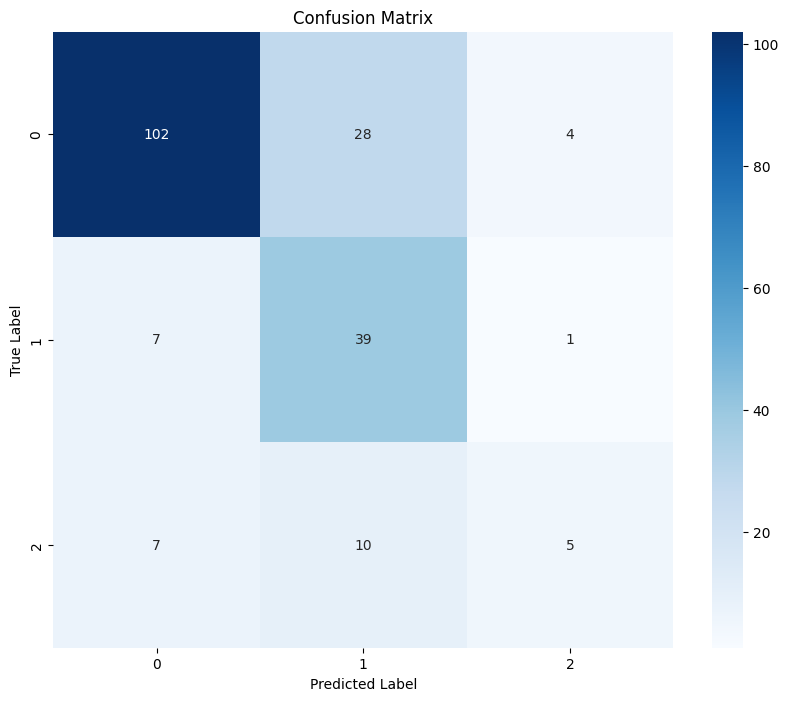

In [28]:
from src.model import evaluate_model
from src.visualization import plot_confusion_matrix

# Evaluate the model
print("Evaluating the model...")
eval_results = evaluate_model(model, X_test, y_test)

# Check if eval_results is not None
if eval_results is not None:
    # Plot confusion matrix
    plot_confusion_matrix(y_test, eval_results['predictions'])
    plt.savefig(os.path.join(reports_dir, 'confusion_matrix.png'))
    plt.close()
else:
    print("Error: evaluate_model function returned None.")

In [29]:
import joblib

# Save the model and vectorizer for later use
model_dir = os.path.join(project_root, 'models')
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

# Save the model
model_path = os.path.join(model_dir, 'comment_sentiments_model.pkl')
joblib.dump(model, model_path)
print(f"Model saved to {model_path}")

# Save the vectorizer
vectorizer_path = os.path.join(model_dir, 'vectorizer.pkl')
joblib.dump(vectorizer, vectorizer_path)
print(f"Vectorizer saved to {vectorizer_path}")

# Save additional model metadata
model_metadata = {
    'creation_date': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S'),
    'number_of_features': X_train.shape[1],
    'target_classes': sorted(list(set(y_train)))
}

metadata_path = os.path.join(model_dir, 'model_metadata.pkl')
joblib.dump(model_metadata, metadata_path)
print(f"Model metadata saved to {metadata_path}")


Model saved to c:\Users\ELITEBOOK\OneDrive\Desktop\Projects\post-comments-sentiment-Analysis\models\comment_sentiments_model.pkl
Vectorizer saved to c:\Users\ELITEBOOK\OneDrive\Desktop\Projects\post-comments-sentiment-Analysis\models\vectorizer.pkl
Model metadata saved to c:\Users\ELITEBOOK\OneDrive\Desktop\Projects\post-comments-sentiment-Analysis\models\model_metadata.pkl
